In [1]:
import h5py
import torch
import torch.nn as nn
from torch.legacy.nn import Reshape
from torch.autograd import Variable
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torch.utils.data as utils
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imresize, imread, imshow
import time
from math import log,sqrt
import torch.nn.functional as F

In [2]:
torch.cuda.current_device()

0

In [3]:
def InitializeWeights(mod):
    for m in mod.modules():
        if isinstance(m,nn.Conv2d):
            n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            #print m.weight.size(), m.out_channels, m.in_channels
            m.weight.data.normal_(0,sqrt(2./n))
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.fill_(1)
            m.bias.data.zero_()
    return mod

In [4]:
class Corridor(nn.Module):

    def __init__(self):
        super(Corridor, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = InitializeWeights(nn.Conv2d(3, 6, 7, 2))
        self.conv2 = InitializeWeights(nn.Conv2d(6, 16, 5, 2))
        self.conv3 = InitializeWeights(nn.Conv2d(16, 20, 3, 1))
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(20 * 4 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.fc4 = nn.Linear(10, 1)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Corridor()
print(net)

Corridor (
  (conv1): Conv2d(3, 6, kernel_size=(7, 7), stride=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(2, 2))
  (conv3): Conv2d(16, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear (640 -> 120)
  (fc2): Linear (120 -> 84)
  (fc3): Linear (84 -> 10)
  (fc4): Linear (10 -> 1)
)


In [5]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

14
torch.Size([6, 3, 7, 7])


In [6]:
sum1 = 0
        
print("Number of layers ---> ",len(list(net.parameters())))
for params in net.parameters():
    if params.requires_grad == True:
        sum1 += params.numel()
    
print("Total number of parameters ---> ",sum1)

Number of layers --->  14
Total number of parameters --->  94149


In [7]:
input = Variable(torch.randn(5, 3, 180, 320))
out = net(input)
print(out)

Variable containing:
 0.1926
 0.1944
 0.1874
 0.1889
 0.1940
[torch.FloatTensor of size 5x1]



In [9]:
file = h5py.File('./DATASET/CODE/NewTrainData.h5')
xtrainT = torch.from_numpy(np.array(file['xtrain'],dtype=np.float32)).float()
ytrainT = torch.from_numpy(np.array(file['ytrain'],dtype=np.float32)).float()
#xtrain = np.array(file['xtrain'],dtype=np.float32)
#ytrain = np.array(file['ytrain'],dtype=np.float32)

In [10]:
file = h5py.File('./DATASET/CODE/NewTestData.h5')
xtestT = torch.from_numpy(np.array(file['xtest'],dtype=np.float32)).float()
ytestT = torch.from_numpy(np.array(file['ytest'],dtype=np.float32)).float()
#xtest = np.array(file['xtest'],dtype=np.float32)
#ytest = np.array(file['ytest'],dtype=np.float32)

In [11]:
def batch_rgb_to_bgr(batch):
    #print(batch.size())
    (r, g, b) = torch.chunk(batch, 3, 1)
    #print(r.size())
    batch1 = torch.cat((b, g, r),1)
    #print(batch1.size())
    return batch1

In [12]:
xtrainT = batch_rgb_to_bgr(xtrainT)
xtestT = batch_rgb_to_bgr(xtestT)
print(xtrainT.size(), xtestT.size())

torch.Size([5670, 3, 180, 320]) torch.Size([912, 3, 180, 320])


In [13]:
xtrainT = torch.div(xtrainT,255.0)
xtestT = torch.div(xtestT,255.0)

In [14]:
print(torch.min(xtrainT), torch.max(xtrainT), torch.min(xtestT), torch.max(xtestT))

0.0 1.0 0.0 1.0


In [15]:
print(xtrainT.size(), ytrainT.size(), xtestT.size(), ytestT.size())

torch.Size([5670, 3, 180, 320]) torch.Size([5670, 2]) torch.Size([912, 3, 180, 320]) torch.Size([912, 2])


In [16]:
class Normalize(object):
    """
    Normalize an tensor image with mean and standard deviation.
    Given mean: (R, G, B) and std: (R, G, B),
    will normalize each channel of the torch.*Tensor, i.e.
    channel = (channel - mean) / std
    Args:
        mean (sequence): Sequence of means for R, G, B channels respecitvely.
        std (sequence): Sequence of standard deviations for R, G, B channels
            respecitvely.
    """

    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        # TODO: make efficient
        for t, m, s in zip(tensor, self.mean, self.std):
            t.sub_(m).div_(s)
        return tensor

In [17]:
mn = [0.406,0.456,0.485]
sd = [0.225,0.224,0.229]
norm = Normalize(mn,sd)
xtrainT = norm(xtrainT)
xtestT = norm(xtestT)

In [18]:
print(torch.min(xtrainT), torch.max(xtrainT), torch.min(xtestT), torch.max(xtestT))

-2.1007792949676514 2.640000104904175 -1.8267831802368164 2.640000104904175


In [19]:
##def train(model, loss, optimizer, x_val, y_val, validPixel, batch_sz):
def train(model, loss, optimizer, x_val, y_val):
    x = Variable(x_val,requires_grad = False).cuda()
    y = Variable(y_val,requires_grad = False).cuda()
    
    optimizer.zero_grad()
    
    fx = model.forward(x)
    
    #print fx.data[0][0][64][87]
    #fx = model5.forward(Variable(xtest2[start:end], volatile=True).cuda())
    ##output = loss.forward(fx,y,validPixel,batch_sz)
    output = loss.forward(fx,y)
    #output = loss(fx, y)
    output.backward()
    
    optimizer.step()
    
    return output.data[0]

In [20]:
#custom loss function.... this will be reverse Huber...

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        
    def forward(self,inp, tar):
        #target is the ground truth value...
        #k = torch.mean(inp[:,0])
        '''
        if (k >= 1.48 and k <= 1.65):
            diff = torch.abs(tar[:,1]-inp[:,1])
            loss = torch.mean(torch.pow(diff,2))
        else:
        '''
        diff = torch.abs(tar[:,0]-inp[:,0]) #*(180/np.pi)
        loss = torch.mean(torch.pow(diff,2))
        #print(loss)
        return loss
        '''
        c1 = c.data[0] 
        temp = diff > c1
        check1 = torch.prod(temp)
        
        if check1 == 0:
            lossval = torch.mean(diff)
        else:
            temp4 = torch.pow(diff,2)
            d = torch.pow(c,2)
            temp4 = temp4.add(d.expand_as(temp4))
            lossval = torch.mean(temp4/(2*c))
        return lossval
        '''

In [24]:
#MUST UNCOMMENT BELOW LINE...
    
net = net.cuda()

#loading the model after the weights of epoch50.. to check what loss the model gives if lr is taken as 0.0001
optimizer = optim.SGD(net.parameters(), lr=1.6000000000000003e-07, momentum=0.9)

#criterion = RMSELoss()
#criterion = BerhuLoss()
#criterion = EuclideanLoss()
#criterion = nn.MSELoss()
#criterion = CosineLoss()
#criterion = torch.nn.MSELoss(size_average=False)
criterion = CustomLoss()
criterion.cuda()

currepochloss = float('Inf')
#epochs, n_examples, i, batch_size, flag = 1,5900, 0, 5, 0
epochs, n_examples, i, batch_size, flag = 300, 5670, 0, 45, 0


while i != epochs:
    since = time.time()
    cost, batchloss = 0.0, 0.0
    num_batches = n_examples//batch_size
    #print num_batches    #indices = np.random.permutation(5600)
    #indices = np.random.permutation(3524)
    
    #indices = np.random.permutation(5900)
    indices = np.random.permutation(n_examples)
    samplesUnprocessed = np.size(indices)
    
    #batchwise training starts here...
    for k in range(num_batches):
        since1 = time.time()
       # print("bacth number:"+str(k))
        xtrain3 = torch.FloatTensor(batch_size,3,180,320)
        ytrain3 = torch.FloatTensor(batch_size,2)
        ##validPixel = torch.FloatTensor(batch_size,480,640)
        
        for ind in range(batch_size):
            #ind1 = np.random.randint(0,5599)
            ind1 = np.random.randint(0,samplesUnprocessed)
            #ind1 = np.random.randint(0,794)
            #ind1 = np.random.randint(0,794)            
            newxind = indices[ind1]            
            xtrain3[ind] = xtrainT[newxind]
            ytrain3[ind] = ytrainT[newxind]
            ##validPixel[ind] = imgValidTrain2[newxind]
            
            #print ytrain3[ind,0,0,0], ytrain2[newxind,0,0,0]
            indices = np.delete(indices,ind1)
            samplesUnprocessed = samplesUnprocessed - 1
        
        #start, end = k*batch_size, (k+1)*batch_size
        #batchloss = train(model5,criterion, optimizer, xtrain3, ytrain3, validPixel,batch_size)
        batchloss = train(net,criterion, optimizer, xtrain3, ytrain3)
        batch_time = time.time() - since1
        #cost += batchloss
        cost = (cost*k+batchloss)/(k+1)
        #print k,cost
        #print("No. of samples UnProcessed "+str(samplesUnprocessed))
        
    time_elapsed = time.time() - since
    epochloss = cost #/num_batches
    
    if epochloss < currepochloss:
        print('save the weights')
        torch.save(net.state_dict(),"./weights/corridor_new_data_bgr_3_NOV.pth")
        flag = 0
        currepochloss = epochloss
    else:
        flag += 1
        
        if flag == 5:
            for p in optimizer.param_groups:
                lr2 = p['lr']
            newlr = lr2/5
            
            if newlr < 1e-15:
                print("Cant decrease further!!")
                newlr = 1e-15
            flag = 0 
            optimizer = optim.SGD(net.parameters(), lr=newlr, momentum=0.9)
            print("Learning rate changed from "+str(lr2)+" to "+str(newlr))
            
        print("Loss "+str(epochloss)+" is bigger than Loss "+str(currepochloss)+" in the prev epoch ")
        
    print('Loss = {:.4f} at epoch {:d} completed in {:.0f}m {:.0f}s'.format(epochloss,(i+1),(time_elapsed//60),(time_elapsed%60)))
    i += 1 

save the weights
Loss = 0.0082 at epoch 1 completed in 0m 3s
save the weights
Loss = 0.0082 at epoch 2 completed in 0m 3s
Loss 0.00817682746139961 is bigger than Loss 0.008175692417555384 in the prev epoch 
Loss = 0.0082 at epoch 3 completed in 0m 3s
Loss 0.008176010004096913 is bigger than Loss 0.008175692417555384 in the prev epoch 
Loss = 0.0082 at epoch 4 completed in 0m 3s
Loss 0.00817585787144564 is bigger than Loss 0.008175692417555384 in the prev epoch 
Loss = 0.0082 at epoch 5 completed in 0m 3s
Loss 0.008176212542734682 is bigger than Loss 0.008175692417555384 in the prev epoch 
Loss = 0.0082 at epoch 6 completed in 0m 3s
save the weights
Loss = 0.0082 at epoch 7 completed in 0m 3s
save the weights
Loss = 0.0082 at epoch 8 completed in 0m 3s
Loss 0.008175498103752496 is bigger than Loss 0.00817520756252287 in the prev epoch 
Loss = 0.0082 at epoch 9 completed in 0m 3s
Loss 0.008175935978735132 is bigger than Loss 0.00817520756252287 in the prev epoch 
Loss = 0.0082 at epoch 1

Learning rate changed from 1.0240000000000002e-11 to 2.048e-12
Loss 0.008172613143595672 is bigger than Loss 0.008172612707500186 in the prev epoch 
Loss = 0.0082 at epoch 71 completed in 0m 3s
Loss 0.00817261305489829 is bigger than Loss 0.008172612707500186 in the prev epoch 
Loss = 0.0082 at epoch 72 completed in 0m 3s
Loss 0.00817261303272394 is bigger than Loss 0.008172612707500186 in the prev epoch 
Loss = 0.0082 at epoch 73 completed in 0m 3s
Loss 0.00817261309555126 is bigger than Loss 0.008172612707500186 in the prev epoch 
Loss = 0.0082 at epoch 74 completed in 0m 3s
Loss 0.00817261304011539 is bigger than Loss 0.008172612707500186 in the prev epoch 
Loss = 0.0082 at epoch 75 completed in 0m 3s
Learning rate changed from 2.048e-12 to 4.0960000000000004e-13
Loss 0.00817261308815981 is bigger than Loss 0.008172612707500186 in the prev epoch 
Loss = 0.0082 at epoch 76 completed in 0m 3s
Loss 0.008172613125117056 is bigger than Loss 0.008172612707500186 in the prev epoch 
Loss = 

Loss 0.008172613171313604 is bigger than Loss 0.008172612707500186 in the prev epoch 
Loss = 0.0082 at epoch 128 completed in 0m 3s
Loss 0.008172612973592348 is bigger than Loss 0.008172612707500186 in the prev epoch 
Loss = 0.0082 at epoch 129 completed in 0m 3s
Loss 0.008172613047506843 is bigger than Loss 0.008172612707500186 in the prev epoch 
Loss = 0.0082 at epoch 130 completed in 0m 3s
Cant decrease further!!
Learning rate changed from 1e-15 to 1e-15
Loss 0.008172613062289733 is bigger than Loss 0.008172612707500186 in the prev epoch 
Loss = 0.0082 at epoch 131 completed in 0m 3s
Loss 0.008172613126964915 is bigger than Loss 0.008172612707500186 in the prev epoch 
Loss = 0.0082 at epoch 132 completed in 0m 3s
Loss 0.008172613051202567 is bigger than Loss 0.008172612707500186 in the prev epoch 
Loss = 0.0082 at epoch 133 completed in 0m 3s
Loss 0.00817261305120256 is bigger than Loss 0.008172612707500186 in the prev epoch 
Loss = 0.0082 at epoch 134 completed in 0m 3s
Loss 0.0081

Loss 0.008172613117725597 is bigger than Loss 0.008172612707500186 in the prev epoch 
Loss = 0.0082 at epoch 185 completed in 0m 3s
Cant decrease further!!
Learning rate changed from 1e-15 to 1e-15
Loss 0.008172613029028214 is bigger than Loss 0.008172612707500186 in the prev epoch 
Loss = 0.0082 at epoch 186 completed in 0m 3s
Loss 0.008172613082616223 is bigger than Loss 0.008172612707500186 in the prev epoch 
Loss = 0.0082 at epoch 187 completed in 0m 3s
Loss 0.008172613073376904 is bigger than Loss 0.008172612707500186 in the prev epoch 
Loss = 0.0082 at epoch 188 completed in 0m 3s
Loss 0.008172613073376904 is bigger than Loss 0.008172612707500186 in the prev epoch 
Loss = 0.0082 at epoch 189 completed in 0m 3s
Loss 0.008172613043811111 is bigger than Loss 0.008172612707500186 in the prev epoch 
Loss = 0.0082 at epoch 190 completed in 0m 3s
Cant decrease further!!
Learning rate changed from 1e-15 to 1e-15
Loss 0.008172613143595674 is bigger than Loss 0.008172612707500186 in the pr

Loss 0.00817261299576669 is bigger than Loss 0.008172612707500186 in the prev epoch 
Loss = 0.0082 at epoch 242 completed in 0m 3s
Loss 0.008172613082616223 is bigger than Loss 0.008172612707500186 in the prev epoch 
Loss = 0.0082 at epoch 243 completed in 0m 3s
Loss 0.008172612966200902 is bigger than Loss 0.008172612707500186 in the prev epoch 
Loss = 0.0082 at epoch 244 completed in 0m 3s
Loss 0.008172613125117053 is bigger than Loss 0.008172612707500186 in the prev epoch 
Loss = 0.0082 at epoch 245 completed in 0m 3s
Cant decrease further!!
Learning rate changed from 1e-15 to 1e-15
Loss 0.008172613108486286 is bigger than Loss 0.008172612707500186 in the prev epoch 
Loss = 0.0082 at epoch 246 completed in 0m 3s
Loss 0.008172613139899951 is bigger than Loss 0.008172612707500186 in the prev epoch 
Loss = 0.0082 at epoch 247 completed in 0m 3s
Loss 0.008172613093703393 is bigger than Loss 0.008172612707500186 in the prev epoch 
Loss = 0.0082 at epoch 248 completed in 0m 3s
Loss 0.0081

Loss 0.008172612951418001 is bigger than Loss 0.008172612707500186 in the prev epoch 
Loss = 0.0082 at epoch 299 completed in 0m 3s
Loss 0.008172613058594016 is bigger than Loss 0.008172612707500186 in the prev epoch 
Loss = 0.0082 at epoch 300 completed in 0m 3s


In [31]:

for params in optimizer.param_groups:
    print(params['lr'])

1e-15


In [32]:
net = net.cuda()
net.load_state_dict(torch.load("./weights/corridor_new_data_bgr_600.pth"))

In [25]:
#testing of the architecture...
num_batches = 0
#6 evenly divides the test batch size..
test_batch_size = 8
n_examples = 912
#finalpred = Variable(torch.zeros((n_examples,3,120,160)))
finalpred = Variable(torch.zeros((n_examples,1)))
print("finalpred size is ---> ", finalpred.size())

num_batches = n_examples//test_batch_size
print("num of batches --->", num_batches)
for k in range(num_batches):
    start, end = k*test_batch_size, (k+1)*test_batch_size
    output = net.forward(Variable(xtestT[start:end], volatile=True).cuda())
    finalpred[start:end] = output

finalpred size is --->  torch.Size([912, 1])
num of batches ---> 114


In [26]:
data1 = finalpred.data.numpy()
print(data1.shape)

(912, 1)


In [28]:
dif = torch.abs(finalpred.data[:,0]-ytestT[:,0])
print(dif.size())
np.savetxt("diff.csv", dif.numpy(), delimiter=",")
MSEloss = torch.mean(torch.pow(dif,2))
ABSloss = torch.mean(dif)
print("MSEloss=="+str(MSEloss),"ABSloss=="+str(ABSloss))

torch.Size([912])
MSEloss==0.4225935859552363 ABSloss==0.49924373502532643


In [40]:
n=887

print(finalpred.data[n,0]*(180/np.pi))
print(ytestT[n,0]*(180/np.pi))
print(ytestT[n,0]*(180/np.pi)-finalpred.data[n,0]*(180/np.pi))

94.9617797666556
43.8015182038607
-51.160261562794894


In [30]:
ABSloss*(180/np.pi)

28.604558965298796

In [35]:
#print(ytestT[:,0]*(180/np.pi))
print(ytestT[:,0]*(180/np.pi))
a = ytestT[:,0]*(180/np.pi)
print(a.size())
np.savetxt("test.csv", a.numpy(), delimiter=",")


  91.1458
  88.8542
  91.1458
  88.8542
  91.1458
  88.8542
  91.1458
  88.8542
  91.1458
  88.8542
  91.1458
  88.8542
  91.1458
  88.8542
  91.1458
  88.8542
  91.1458
  88.8542
  91.1458
  88.8542
  91.1458
  88.8542
  91.1458
  88.8542
  49.5078
 130.4922
  49.5078
 130.4922
  49.5078
 130.4922
  49.5078
 130.4922
  49.5078
 130.4922
  49.5078
 130.4922
  49.5078
 130.4922
  49.5078
 130.4922
  49.5078
 130.4922
  49.5078
 130.4922
  49.5078
 130.4922
  49.5078
 130.4922
  48.2572
 131.7428
  48.2572
 131.7428
  48.2572
 131.7428
  48.2572
 131.7428
  48.2572
 131.7428
  48.2572
 131.7428
  48.2572
 131.7428
  48.2572
 131.7428
  48.2572
 131.7428
  48.2572
 131.7428
  48.2572
 131.7428
  48.2572
 131.7428
  45.0000
 135.0000
  45.0000
 135.0000
  45.0000
 135.0000
  45.0000
 135.0000
  45.0000
 135.0000
  45.0000
 135.0000
  45.0000
 135.0000
  45.0000
 135.0000
  45.0000
 135.0000
  45.0000
 135.0000
  45.0000
 135.0000
  45.0000
 135.0000
 133.6780
  46.3220
 133.6780
  46.3220

In [42]:
a = np.asarray([ [1,2,3], [4,5,6], [7,8,9] ])
np.savetxt("foo.csv", a, delimiter=",")

In [39]:
#print(finalpred.data[:,0]*(180/np.pi))
print(finalpred.data[:,0]*(180/np.pi))
b = finalpred.data[:,0]*(180/np.pi)
c=torch.abs(ytestT[:,0]*(180/np.pi)- finalpred.data[:,0]*(180/np.pi))
np.savetxt("pred.csv", b.numpy(), delimiter=",")

np.savetxt("diff.csv", c.numpy(), delimiter=",")


 173.5292
 224.8487
 282.5188
 107.4965
  98.2198
 105.7313
  89.3513
 101.4670
  81.5013
  94.8344
  87.1014
  86.9526
  96.5917
  82.2452
  90.9523
  76.5235
  85.9288
  74.4137
  79.8457
  68.9614
  73.6388
  72.2270
  68.8498
 109.9282
  48.3227
 141.1301
  52.6376
 129.2402
  48.7278
 124.6510
  45.8315
 124.2019
  56.5810
 120.8452
  56.7226
 110.9932
  54.9241
 128.3802
  67.4745
 150.6300
  68.0510
 140.2196
  66.3954
 131.0873
  49.7283
 123.9580
  58.4041
 138.0071
  37.4412
 135.9435
  44.2135
 137.0186
  49.5745
 126.6363
  42.3295
 125.9399
  48.1420
 149.1017
  45.8872
 154.6732
  31.8942
 140.1601
  47.6222
 150.1557
  75.6302
 144.4570
  73.6798
 122.6927
  74.9949
 138.5825
  79.7916
 120.4884
 119.4312
  74.2788
 135.4987
  54.1329
  98.6279
  55.7520
  99.7668
  83.5860
  86.2377
  91.8369
  86.9140
  92.9795
  84.8558
  81.5958
  89.3448
 108.6319
  82.8587
  73.4166
  80.8266
  97.5872
  97.0835
  82.3764
  83.2804
  73.5336
 162.1739
  47.3875
 164.0884
  49.0205

In [31]:
finalpred.data[1,0]

1.4546151161193848

(1008, 736, 3)
Angle===58.387817478340644 1.019059658050537


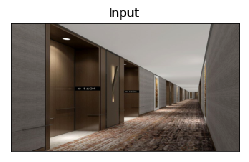

In [44]:
import scipy
from scipy.misc import imresize, imread, imshow
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'
%matplotlib inline

fig = plt.figure()
fig.set_figheight(9)
fig.set_figwidth(9)
import cv2

test = cv2.imread("./Test_Net_image/4.JPG")
print(test.shape)
test = imresize(test,(180,320,3))
#imshow(test)
test = test.transpose(2,0,1)
test = np.reshape(test,(1,3,180,320))
test = test.astype(np.float32)
testPT = torch.from_numpy(test).float()
testPT = batch_rgb_to_bgr(testPT)
testPT = torch.div(testPT,255.0)
mn = [0.406,0.456,0.485]
sd = [0.225,0.224,0.229]
norm = Normalize(mn,sd)
testPT = norm(testPT)
'''
ind = 2000
testPT = xtestT[ind]
print("Actual angle==="+str(ytestT[ind,0]*(180/np.pi)), ytestT[ind,0])
testPT = testPT.view(1,3,180,320)
#'''
test_pred = net.forward(Variable(testPT, volatile=True).cuda())
print("Angle==="+str(test_pred.data[0,0]*(180/np.pi)), test_pred.data[0,0])
testx = testPT.numpy()
testx = np.reshape(testx,(3,180,320))
testx = testx.transpose(1,2,0)
testx = imresize(testx,(180,320,3))
#imshow(testx)
scipy.misc.imsave('test.png', testx)
a=fig.add_subplot(1,2,1)
imgplot = plt.imshow(testx)
a.set_title('Input')
a.axes.get_xaxis().set_visible(False)
a.axes.get_yaxis().set_visible(False)